In [3]:
using DataFrames, CSV, JuMP, Gurobi, Metrics, Plots, StatsBase

In [4]:
# load data
train_valid = CSV.read("train_valid.csv", DataFrame)
test = CSV.read("test.csv", DataFrame);

In [5]:
# define target and features
target = "fee";

## Define functions that will be used across models

In [7]:
function get_features(df)
    return select(df, Not(target))
end

get_features (generic function with 1 method)

In [8]:
function get_target(df)
    return df[:, target]
end

get_target (generic function with 1 method)

In [9]:
function compute_results(pred, test)
    # compute the mean absolute error
    mae = Metrics.mae(pred, test)
    # compute the mean squared error
    mse = Metrics.mse(pred, test)
    # compute the root mean squared error
    rmse = sqrt.(mse)
    # compute the r2
    osr2 = 1 - sum((test .- pred).^2) / sum((test .- mean(test)).^2)

    # turn into dataframe
    results = DataFrame(mae = mae, mse = mse, rmse = rmse, osr2 = osr2)

    # print the results
    display(results)
end

compute_results (generic function with 1 method)

In [10]:
function check_prediction_value(pred, test)

    # set plot dimensions
    plot_size = (800, 400)
    
    histogram(pred, label = "pred", color = "red", seriesalpha = 0.5)
    display(histogram!(test, label = "test", color = "blue", seriesalpha = 0.5))

end

check_prediction_value (generic function with 1 method)

## ORT (Optimal Regression Trees)

In [9]:
# define ranges for the hyperparameters
max_depth = [3, 4, 5]
minbucket = [2, 5, 10]
;

In [114]:
function ORT_model(train_valid, test)

    # define the model  
    model_oct = IAI.OptimalTreeRegressor(
        random_seed = 1,
        criterion = :mse,
    )

    # define the grid
    grid_oct = IAI.GridSearch(
        model_oct,
        max_depth = max_depth,
        minbucket = minbucket,
    )

    # fit the model with 5-fold cross validation
    IAI.fit_cv!(grid_oct, get_features(train_valid), Array(get_target(train_valid)), validation_criterion = :mse, n_folds=5)

    # get the best model
    pred = IAI.predict(grid_oct, get_features(test))

    # compute the results
    compute_results(pred, get_target(test))

    # check the prediction value
    check_prediction_value(pred, get_target(test))

    # return the best model
    return IAI.get_learner(grid_oct)
end

ORT_model (generic function with 1 method)

,mae,mse,rmse,osr2
,Float64,Float64,Float64,Float64
1,5.4493,80.3567,8.96419,0.347354


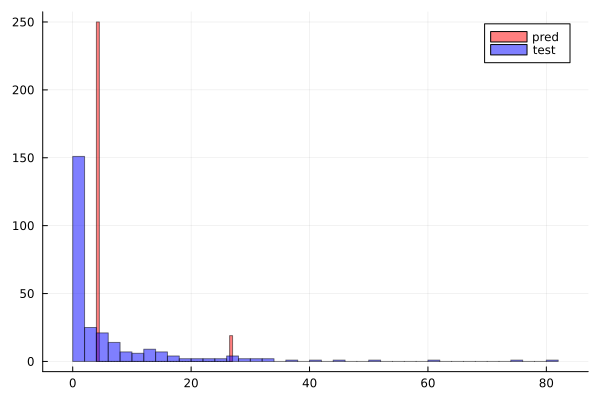

In [115]:
OCTReg = ORT_model(train_valid, test);

## ORT-H (Optimal Regression Trees with Hyperplane Splitting)

In [24]:
# define ranges for the hyperparameters
max_depth = [3, 4]
minbucket = [2, 5]
;

In [21]:
function ORTH_model(train_valid, test)

    print(1)

    # define the model  
    model_octh = IAI.OptimalTreeRegressor(
        random_seed = 1,
        criterion = :mse,
        hyperplane_config= (sparsity=:all,),
    )

    print(2)

    # define the grid
    grid_octh = IAI.GridSearch(
        model_octh,
        max_depth = max_depth,
        minbucket = minbucket,
    )

    print(3)

    # fit the model with 5-fold cross validation
    IAI.fit_cv!(grid_octh, get_features(train_valid), Array(get_target(train_valid)), validation_criterion = :mse, n_folds=5)

    # get the best model
    pred = IAI.predict(grid_octh, get_features(test))

    # compute the results
    compute_results(pred, get_target(test))

    # check the prediction value
    check_prediction_value(pred, get_target(test))

    # return the best model
    return IAI.get_learner(grid_octh)
end

ORTH_model (generic function with 1 method)

In [ ]:
ORTHReg = ORTH_model(train_valid, test);

Was taking such a long time to run...
Let's try again

## ORT-L (Optimal Regression Tree with Linear Regression on the leaves)

In [32]:
function ORTL_model(train_valid, test)

    # define the model  
    model_octl = IAI.OptimalTreeRegressor(
        random_seed = 1,
        criterion = :mse,
        max_depth = 4,
        minbucket = 15,
        regression_features = All(),
    )

    # define the grid
    grid_octl = IAI.GridSearch(
        model_octl,
        regression_lambda=[0.01, 0.05, 0.1]
    )

    # fit the model with 5-fold cross validation
    IAI.fit_cv!(grid_octl, get_features(train_valid), Array(get_target(train_valid)), validation_criterion = :mse, n_folds=5)

    # get the best model
    pred = IAI.predict(grid_octl, get_features(test))

    # compute the results
    compute_results(pred, get_target(test))

    # check the prediction value
    check_prediction_value(pred, get_target(test))

    # return the best model
    return IAI.get_learner(grid_octl)
end

ORTL_model (generic function with 1 method)

In [ ]:
ORTLReg = ORTL_model(train_valid, test);

## Holistic regression

In [12]:
function pairwise_correlation(data, rho)

    cor_matrix = cor(Matrix(data))

    # we know that the matrix is symmetrix
    # no need to include the correlation between one variable and itself, of course it is 1
    
    p = size(cor_matrix)[1]

    # list to record the variables with which X[i] is correlated
    correlated = []

    for i = 1:(p-1)     
        for j = (i+1):p
            if abs(cor_matrix[i, j]) > rho
                push!(correlated, (i, j))
            end
        end
    end

    return correlated
end

pairwise_correlation (generic function with 1 method)

In [13]:
function HolisticRegression(X, y, lambda, k, rho)

    # define the model
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "OutputFlag", 0)

    # PARAMETERS

    n, p = size(X)

    M = 1000

    # call function pairwise_correlation to define HC(X)
    HC = pairwise_correlation(X, rho)

    # VARIABLES

    @variable(model, beta[1:p])
    @variable(model, t)
    @variable(model, r)
    @variable(model, q[1:p])
    @variable(model, z[1:p], binary = true) # binary variable

    # OBJECTIVE FUNCTION

    @objective(model, Min, t + lambda * r)

    # CONSTRAINTS

    @constraint(model, t >= sum((y[i]-sum(X[i,j]*beta[j] for j=1:p))^2 for i=1:n)) # to rewrite objective function
    @constraint(model, r >= sum(q[j] for j=1:p)) # to rewrite objective function
    @constraint(model, [j=1:p], q[j] >= beta[j]) # to rewrite objective function
    @constraint(model, [j=1:p], q[j] >= -beta[j]) # to rewrite objective function

    @constraint(model, [i=1:p], beta[i]<=M*z[i]) # sparsity
    @constraint(model, [i=1:p], beta[i]>=-M*z[i]) # sparsity
    @constraint(model, sum(z[i] for i=1:p) <= k) # sparsity

    # pairwise collinearity
    for (i,j) in HC
        @constraint(model, z[i] + z[j] <= 1) 
    end

    
    # nonlinear transformation

    # group sparsity

    # significance

    # multicollinear relations

    # OPTIMIZE

    optimize!(model)

    return objective_value(model), value.(beta)

end

HolisticRegression (generic function with 1 method)

In [19]:
function Holistic_model(train_valid, test)

    p_total = size(get_features(train_valid))[2]

    # initialize best model
    obj, best_beta = HolisticRegression(get_features(train_valid), get_target(train_valid), 0, p_total, 0.5)

    # run HolisticRegression for different values of lambda and k, save lambda and k that give the best results
    for lambda in [0.1, 0.5] 
        for k in [floor(sqrt(p_total)), floor(p_total/2)]
            for rho in [0.7, 0.9]
                obj_, beta_ = HolisticRegression(get_features(train_valid), get_target(train_valid), lambda, k, rho)
                if obj_ < obj
                    best_beta = beta_
                end
            end
        end
        break
    end

    # define model with best beta, select features corresponding to non-zero beta
    features_keep_sorted = [i for (i, beta) in enumerate(best_beta) if beta != 0]

    # make predictions using the best model (y = X * beta)
    pred = Matrix(get_features(test)[:, features_keep_sorted]) * best_beta[features_keep_sorted]

    # compute the results
    compute_results(pred, get_target(test))

    # check the prediction value
    check_prediction_value(pred, get_target(test))

    # return the best model
    return best_beta
end

Holistic_model (generic function with 1 method)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-17
Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-17
Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-17
Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-17
Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-17


,mae,mse,rmse,osr2
,Float64,Float64,Float64,Float64
1,5.74002,84.2982,9.18141,0.315342


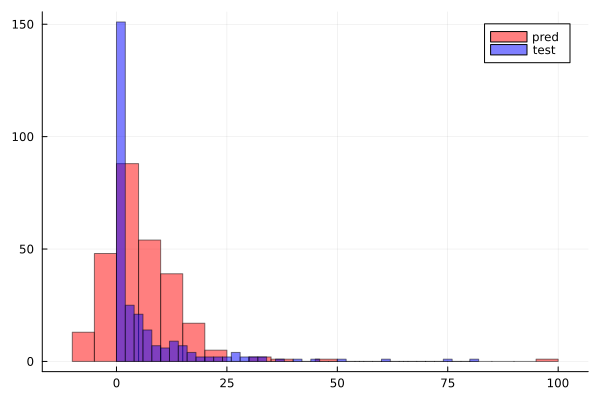

In [20]:
HolReg_betas = Holistic_model(train_valid, test);